# Artificial Neural Network Visualization

This notebook is an exercise in visualizing Artificial Neural Networks. Please see [MNIST_ANN](MNIST_ANN.ipynb) for the basics.

## Table of contents (NEEDS UPDATED):

* [Imported Libraries](#imports)
* [Loading MNIST Dataset](#load)
  - [Viewing the data](#view)
* [Preprocess the data](#preprocess)
  - [Reshape and normalize image data](#reshape)
  - [Process the labels](#labels)
* [Flat neural network](#simple)
  - [Define model architecture](#model)
  - [Evaluate model](#simple-evaluate)
* [Flat: Adam](#simple-adam)
* [Flat: Dense](#simple-dense)
* [Simple convolutional](#conv-simple)
* [Multi-layer convolutional network](#conv-simple)

# Imported Libraries <a class="anchor" id="imports"></a>

Start by importing the following libraries.

**NOTE:**

- Versions for keras, tensorflow, scikit-learn
    * You may install these versions in anaconda *via* `$: conda install keras=2.2.2`
- If you have an Nvidia gpu, you can install gpu-enabled versions of tensorflow/keras for improved performance:
    * `$: conda install -c defaults tensorflow-gpu keras-gpu`

In [1]:
%matplotlib notebook
import numpy as np
np.random.seed(123)
from matplotlib import pyplot as plt

import keras
print(f"keras version: {keras.__version__}")
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils
from keras.datasets import mnist
from keras import backend as K
from keras.callbacks import EarlyStopping, TensorBoard
import tensorflow as tf
print(f"tensorflow version: {tf.__version__}")

###################################
# TensorFlow wizardry
config = tf.ConfigProto()
 
# Don't pre-allocate memory; allocate as-needed
config.gpu_options.allow_growth = True
 
# Only allow a total of half the GPU memory to be allocated
# config.gpu_options.per_process_gpu_memory_fraction = 0.5
 
# Create a session with the above options specified.
K.tensorflow_backend.set_session(tf.Session(config=config))
###################################

import os

import sklearn
print(f"scikit-learn version: {sklearn.__version__}")
from sklearn import metrics

from time import time

Using TensorFlow backend.


keras version: 2.2.4
tensorflow version: 1.12.0
scikit-learn version: 0.20.0


In [2]:
def log_progress(sequence, every=None, size=None, name='Items'):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{name}: {index} / ?'.format(
                        name=name,
                        index=index
                    )
                else:
                    progress.value = index
                    label.value = u'{name}: {index} / {size}'.format(
                        name=name,
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = "{name}: {index}".format(
            name=name,
            index=str(index or '?')
        )

# Load MNIST Dataset <a class="anchor" id="load"></a>

In this example we will use the MNIST dataset from keras. This dataset is nx28x28 in size, and is already nicely split into training and testing data

In [3]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
print("Training data shape")
print(X_train.shape)
print("Testing data shape")
print(X_test.shape)
print((np.nanmin(X_train), np.nanmax(X_train)))

Training data shape
(60000, 28, 28)
Testing data shape
(10000, 28, 28)
(0, 255)


# Preprocess the data <a class="anchor" id="preprocess"></a>

Before we can start to build and train our neural network, we first need to preprocess the data so that the keras framework can understand and interpret it

## Reshape and normalize image data <a class="anchor" id="reshape"></a>

"Typical" image data is RGB and would have a shape Nx28x28x3. This data is greyscale, so the shape needs to be Nx28x28x1. Our data is only Nx28x28, so we need to add an additional dimension for Keras to appropriately handle

We will alsoconvert to float32 and normalize the inputs to [0,1]. While this isn't strictly necessary, normalizing input data tends to improve performance

In [4]:
# reshape the data
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)
# cast to float32
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
# normalize inputs
X_train /= 255
X_test /= 255

## Process the labels <a class="anchor" id="labels"></a>

As provided, the labels are directly associated with the data, i.e.

`y_train[9] = 4 # the 10th data point is an image of a "4"`

Because the output of our neural network will be 10 neurons, each associated with a digit, we need the labels to be categorized: rather than `y_train[9] = 4`, we need `y_train[9] = [0, 0, 0, 0, 1, 0, 0, 0, 0, 0]`

We use `np_utils.to_categorical` to achieve this

In [5]:
y_train = np_utils.to_categorical(y_train, 10)
y_test = np_utils.to_categorical(y_test, 10)

In [23]:
import gc
del model
K.clear_session()
gc.collect()

103443

# Visualizing the Neural Network layers

Artificial neural networks are often referred to as "black boxes" because the weighting and outputs of the layers are not easy to view (and as we will see, are not necessarily easy to inuit/interpret when we can).

Here we create another neural net, this time with 3 convolutional layers before a maxpooling layer. We will then view the output of each layer after training when supplied with an image.

In [17]:
if os.path.exists("VizModel.h5"):
    model = keras.models.load_model("VizModel.h5")
else:

    model = Sequential()

    model.add(Convolution2D(32, (5, 5), activation='relu', padding="Same",
                            input_shape=(28, 28, 1), name="Conv1D_1"))
    convout1 = Activation('relu', name="Act1")
    model.add(convout1)

#     model.add(Convolution2D(32, (5, 5), activation='relu', padding="Same", name="Conv1D_2"))
#     convout2 = Activation('relu', name="Act2")
#     model.add(convout2)

#     model.add(Convolution2D(32, (5, 5), activation='relu', padding="Same", name="Conv1D_3"))
#     convout3 = Activation('relu', name="Act3")
#     model.add(convout3)

    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Convolution2D(64, (5, 5), activation='relu', padding="Same", name="Conv1D_4"))
    convout4 = Activation('relu', name="Act4")
    model.add(convout4)

#     model.add(Convolution2D(64, (5, 5), activation='relu', padding="Same", name="Conv1D_5"))
#     convout5 = Activation('relu', name="Act5")
#     model.add(convout5)

#     model.add(Convolution2D(64, (5, 5), activation='relu', padding="Same", name="Conv1D_6"))
#     convout6 = Activation('relu', name="Act6")
#     model.add(convout6)

    model.add(MaxPooling2D(pool_size=(2,2)))

#     model.add(Convolution2D(128, (5, 5), activation='relu', padding="Same", name="Conv1D_7"))
#     convout7 = Activation('relu', name="Act7")
#     model.add(convout7)

#     model.add(Convolution2D(128, (5, 5), activation='relu', padding="Same", name="Conv1D_8"))
#     convout8 = Activation('relu', name="Act8")
#     model.add(convout8)

    model.add(Convolution2D(128, (5, 5), activation='relu', padding="Same", name="Conv1D_9"))
    convout9 = Activation('relu', name="Act9")
    model.add(convout9)

    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Dropout(0.25))
    maxout = Activation('relu')
    model.add(maxout)

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
#     model.add(Dense(64, activation='relu'))
#     model.add(Dropout(0.5))
#     model.add(Dense(32, activation='relu'))
#     model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))

    early_stop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=10, verbose=1)
    tensorboard = TensorBoard(log_dir="logs/{}".format(time()))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.fit(X_train, y_train, batch_size=512, epochs=100, validation_data=(X_test, y_test),
              callbacks=[early_stop, tensorboard])

    model.summary()
    score = model.evaluate(X_test, y_test)
    print(score)

    y_pred = model.predict(X_test)
    cm = metrics.confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))

    print("Classification report for classifier %s:\n%s\n"
          % (model, metrics.classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1))))
    print("Confusion matrix:\n%s" % cm)

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 5s 77us/step - loss: 0.4622 - acc: 0.8531 - val_loss: 0.0673 - val_acc: 0.9778
Epoch 2/100
60000/60000 [==============================] - 4s 62us/step - loss: 0.0977 - acc: 0.9708 - val_loss: 0.0427 - val_acc: 0.9867
Epoch 3/100
60000/60000 [==============================] - 4s 62us/step - loss: 0.0670 - acc: 0.9799 - val_loss: 0.0313 - val_acc: 0.9892
Epoch 4/100
60000/60000 [==============================] - 4s 62us/step - loss: 0.0514 - acc: 0.9855 - val_loss: 0.0269 - val_acc: 0.9905
Epoch 5/100
60000/60000 [==============================] - 4s 61us/step - loss: 0.0418 - acc: 0.9875 - val_loss: 0.0210 - val_acc: 0.9923
Epoch 6/100
60000/60000 [==============================] - 4s 60us/step - loss: 0.0340 - acc: 0.9897 - val_loss: 0.0214 - val_acc: 0.9924
Epoch 7/100
60000/60000 [==============================] - 4s 61us/step - loss: 0.0296 - acc: 0.9911 - val_loss: 0.0205 - 

In [20]:
if not os.path.exists("VizModel.h5"):
    model.save("VizModel.h5")

In [7]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Visualize the kernels

Let's start with the simplest visualization: Visualizing the kernels. These are the convolutions that transform the input image.

<IPython.core.display.Javascript object>


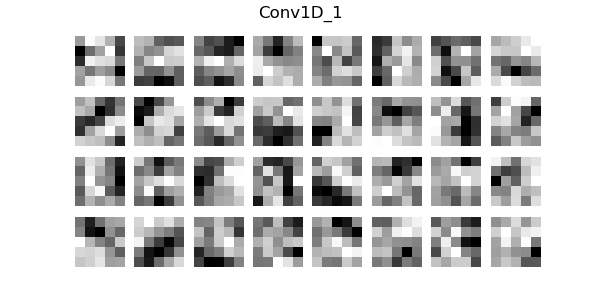

<IPython.core.display.Javascript object>


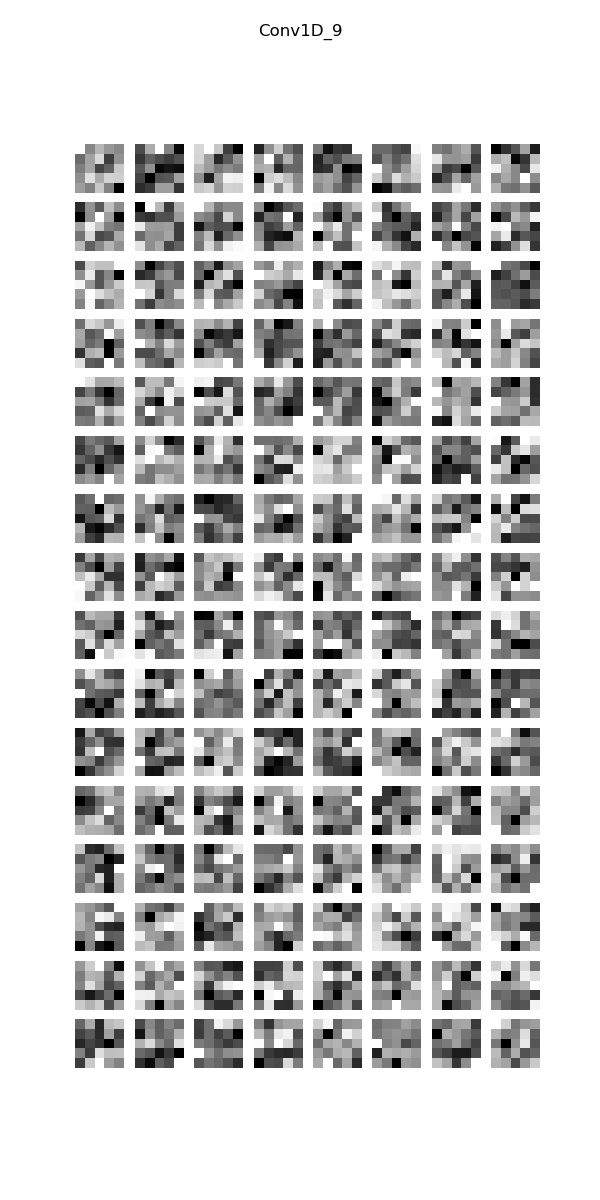

In [22]:
layer_dict = dict([(layer.name, layer) for layer in model.layers])

# layers_to_visualize = ["Conv1D_1", "Conv1D_2", "Conv1D_3",
#                        "Conv1D_4", "Conv1D_5", "Conv1D_6",
#                        "Conv1D_7", "Conv1D_8", "Conv1D_9"]
layers_to_visualize = ["Conv1D_1", "Conv1D_9"]

inputs = [K.learning_phase()] + model.inputs


for layer_name in layers_to_visualize:
    l_layer = layer_dict[layer_name]
#     l_inputs = [K.learning_phase()] + model.inputs
    l_weights = l_layer.get_weights()[0][:,:,0,:]
    col_size = 8
    row_size = l_weights.shape[2] // col_size
    fig_width = 6
    fig, ax = plt.subplots(row_size, col_size, figsize=(fig_width,fig_width/col_size*row_size))
    filter_index = 0
    for row in range(0,row_size): 
        for col in range(0,col_size):
            ax[row][col].imshow(l_weights[:,:,filter_index], cmap="gray")
            ax[row][col].axis("off")
            filter_index += 1
#     plt.subplots_adjust(wspace=0.02)
    fig.suptitle(layer_name)
    plt.show()

Unfortunately, that's not all that helpful. What about looking at the transformed image?

# View the transformed images

Now to view the transformed images

<IPython.core.display.Javascript object>


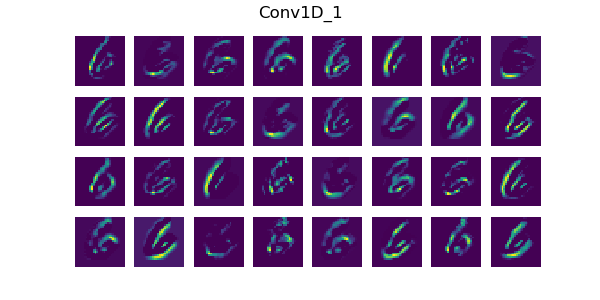

<IPython.core.display.Javascript object>


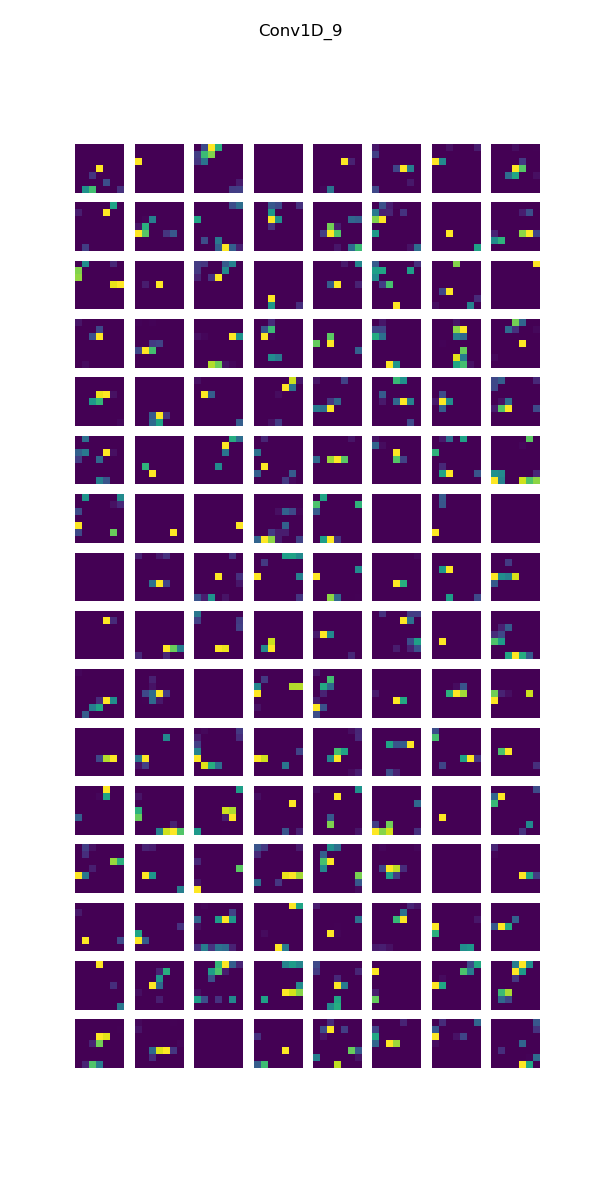

In [23]:
layer_dict = dict([(layer.name, layer) for layer in model.layers])

# layers_to_visualize = ["Conv1D_1", "Conv1D_2", "Conv1D_3",
#                        "Conv1D_4", "Conv1D_5", "Conv1D_6",
#                        "Conv1D_7", "Conv1D_8", "Conv1D_9"]
layers_to_visualize = ["Conv1D_1", "Conv1D_9"]
img_to_visualize = np.expand_dims(X_train[13], axis=0)
    
for layer_name in layers_to_visualize:
    l_layer = layer_dict[layer_name]
    l_inputs = [K.learning_phase()] + model.inputs

    _convout1_f = K.function(inputs, [l_layer.output])
    def convout1_f(X):
        # The [0] is to disable the training phase flag
        return _convout1_f([0] + [X])

    # compute the convolutional output of the layer given
    # the input image
    # e.g. The first layer will take a 28x28 image and will use
    # a Convolution2D layer to pass a 3x3 kernel to create 32 filters
    # meaning 1 28x28x1 image becomes 32 26x26x1 images
    convolutions = convout1_f(img_to_visualize)
    # use the squeeze function dump the channel data
    convolutions = np.squeeze(convolutions)
        
    col_size = 8
    row_size = convolutions.shape[2] // col_size
    fig_width = 6
    fig, ax = plt.subplots(row_size, col_size, figsize=(fig_width,fig_width/col_size*row_size))
    filter_index = 0
    for row in range(0,row_size): 
        for col in range(0,col_size):
            ax[row][col].imshow(convolutions[:,:,filter_index])
            ax[row][col].axis("off")
            filter_index += 1
    fig.suptitle(layer_name)
    plt.show()

What about looking at the "maximum" activations for a particular layer?

# Visualizing the "activations"

In [8]:
import gc
del model
K.clear_session()
gc.collect()
if os.path.exists("VizModel.h5"):
    model = keras.models.load_model("VizModel.h5")

In [26]:
from vis.visualization import visualize_activation
from vis.utils import utils
from keras import activations
from vis.input_modifiers import Jitter
from vis.visualization import get_num_filters

<IPython.core.display.Javascript object>


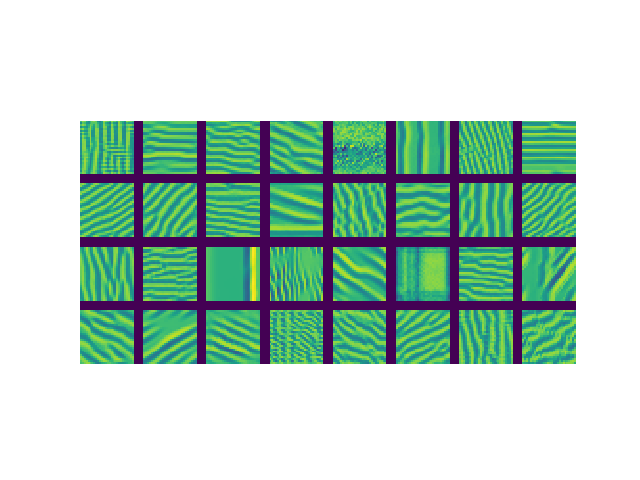

In [27]:
# model.layers[-1].activation = activations.linear
# model = utils.apply_modifications(model)

layer_dict = dict([(layer.name, layer) for layer in model.layers])

layer_name = "Conv1D_1"
layer_idx = utils.find_layer_idx(model, layer_name)
num_filters = get_num_filters(model.layers[layer_idx])
filters = np.arange(num_filters)
col_size = 8
row_size = num_filters // col_size
fig_width = 18
vis_images = list()
for idx in log_progress(filters):
    row = idx // col_size
    col = idx % col_size
    img = visualize_activation(model, layer_idx=layer_idx, filter_indices=idx,
                               tv_weight=0.0, input_modifiers=[Jitter(0.05)])
#     img = utils.draw_text(img, "Filter {}".format(idx))
    vis_images.append(img)
stitched = utils.stitch_images(vis_images, cols=8)

plt.figure()
plt.axis("off")
plt.imshow(stitched[:,:,0], interpolation="None")
plt.show()

<IPython.core.display.Javascript object>


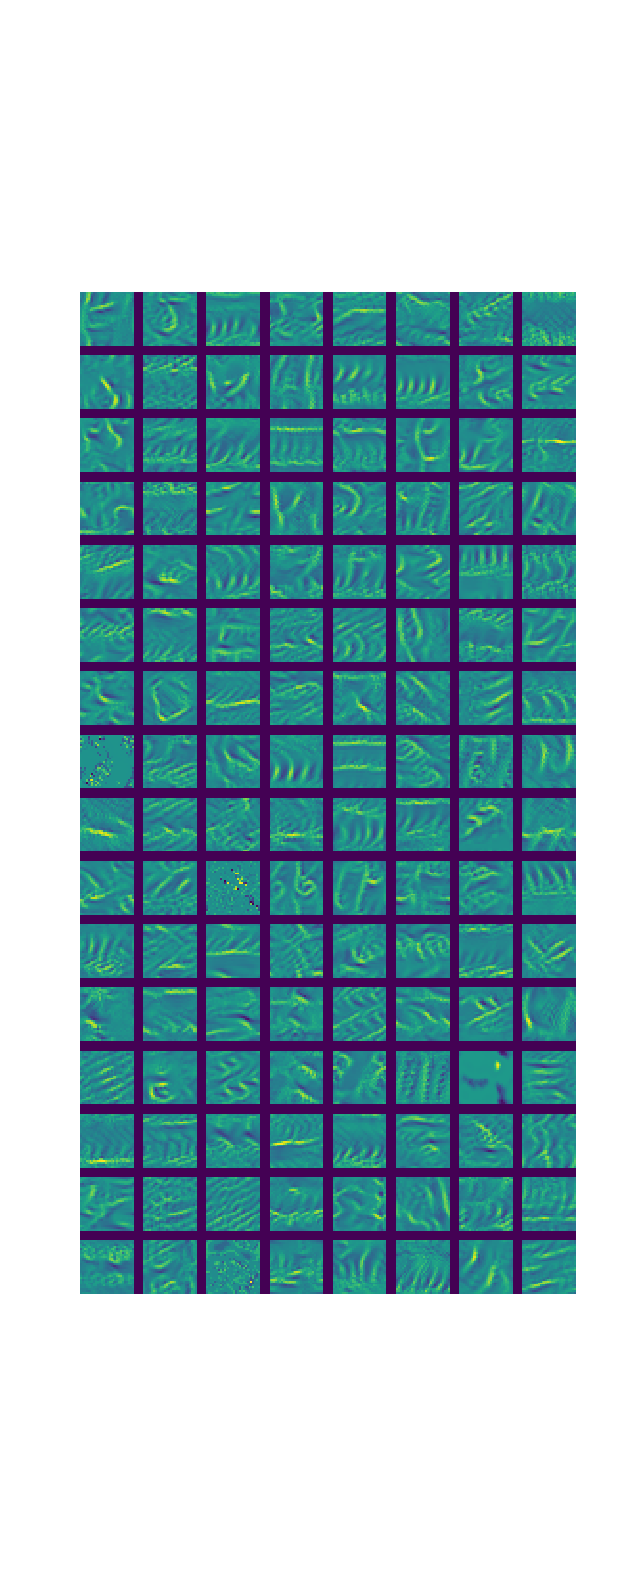

In [28]:
layer_dict = dict([(layer.name, layer) for layer in model.layers])

layer_name = "Conv1D_9"
layer_idx = utils.find_layer_idx(model, layer_name)
num_filters = get_num_filters(model.layers[layer_idx])
filters = np.arange(num_filters)
col_size = 8
row_size = num_filters // col_size
fig_width = 18
vis_images = list()
for idx in log_progress(filters):
    row = idx // col_size
    col = idx % col_size
    img = visualize_activation(model, layer_idx=layer_idx, filter_indices=idx,
                               tv_weight=0.0, input_modifiers=[Jitter(0.05)])
#     img = utils.draw_text(img, "Filter {}".format(idx))
    vis_images.append(img)
stitched = utils.stitch_images(vis_images, cols=8)

plt.figure()
plt.axis("off")
plt.imshow(stitched[:,:,0], interpolation="None")
plt.show()

<IPython.core.display.Javascript object>


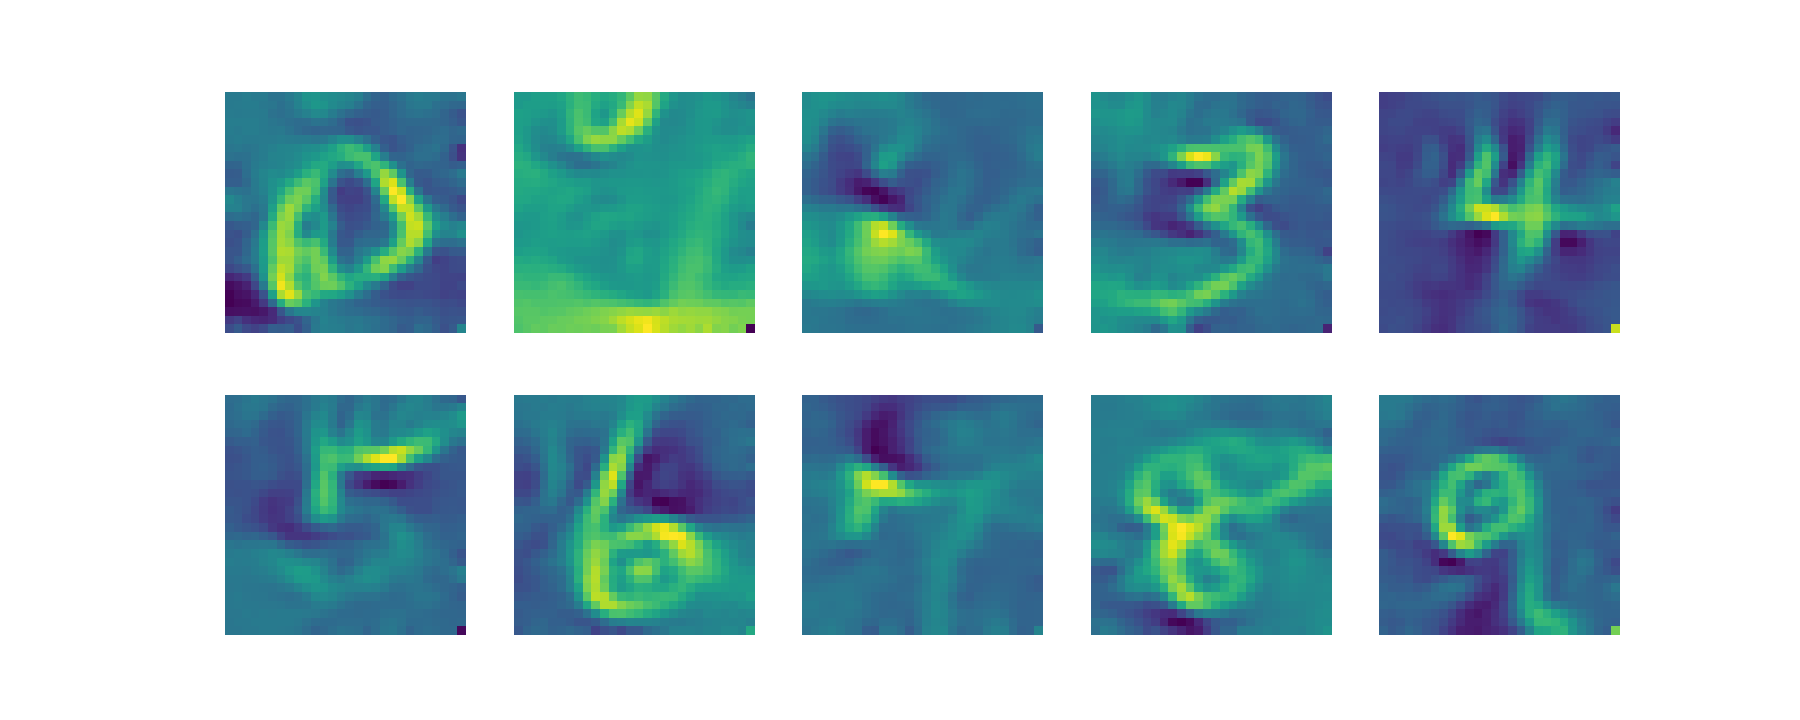

In [29]:
model.layers[-1].activation = activations.linear
model = utils.apply_modifications(model)

row_size=2
col_size=5
fig_width=18
fig, ax = plt.subplots(row_size, col_size, figsize=(fig_width,fig_width/col_size*row_size))
vis_imgs = list()
for img_idx in log_progress(range(10)):
    img = visualize_activation(model, layer_idx=-1, filter_indices=img_idx, input_range=(0., 1.),
                               tv_weight=0., input_modifiers=[Jitter(0.05)])
    vis_imgs.append(img)
for img_idx in log_progress(range(10)):
    img = visualize_activation(model, layer_idx=-1, filter_indices=img_idx, input_range=(0., 1.),
                               seed_input=vis_imgs[img_idx])
    row = img_idx // 5
    col = img_idx % 5
    ax[row][col].imshow(img.reshape(28,28))
    ax[row][col].axis("off")

plt.show()

# OLD CODE BELOW

<IPython.core.display.Javascript object>


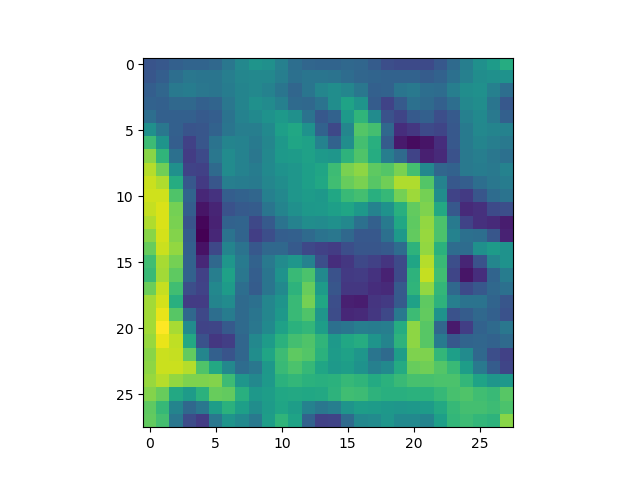

In [16]:
img = visualize_activation(model, layer_idx=-1, filter_indices=0)
plt.figure()
plt.imshow(img.reshape(28, 28))
plt.show()

# Visualize The Learned Categories

<IPython.core.display.Javascript object>


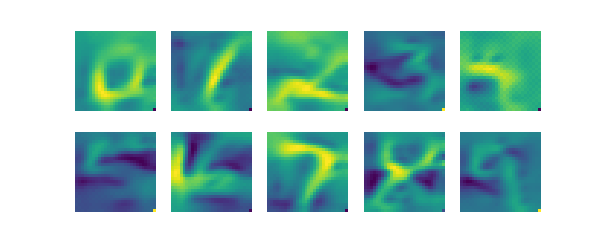

In [32]:
# dimensions of the generated pictures for each filter.
img_width = 28
img_height = 28

# util function to convert a tensor into a valid image

def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + K.epsilon())
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    if K.image_data_format() == 'channels_first':
        x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x

def normalize(x):
    # utility function to normalize a tensor by its L2 norm
    return x / (K.sqrt(K.mean(K.square(x))) + K.epsilon())

from vis.visualization import visualize_activation
from vis.utils import utils
from keras import activations

model.layers[-1].activation = activations.linear
model = utils.apply_modifications(model)

layer_dict = dict([(layer.name, layer) for layer in model.layers])

inputs = [K.learning_phase()] + model.inputs

input_img = model.input

row_size=2
col_size=5
fig_width=6
fig, ax = plt.subplots(row_size, col_size, figsize=(fig_width,fig_width/col_size*row_size))
for img_idx in log_progress(range(10)):
    img = visualize_activation(model, layer_idx=-1, filter_indices=img_idx)
    
    row = img_idx // 5
    col = img_idx % 5
    ax[row][col].imshow(img.reshape(28,28))
    ax[row][col].axis("off")

plt.show()

In [9]:
# choose any image to want by specifying the index
img_to_visualize = X_train[13]
# Keras requires the image to be in 4D
# So we add an extra dimension to it.
img_to_visualize = np.expand_dims(img_to_visualize, axis=0)

def layer_to_visualize(layer, my_title):
    """
    compute the output of the convolutional and maxpool layers
    
    requires the use of particular backend flags to turn off
    training behavior
    """
    inputs = [K.learning_phase()] + model.inputs

    _convout1_f = K.function(inputs, [layer.output])
    def convout1_f(X):
        # The [0] is to disable the training phase flag
        return _convout1_f([0] + [X])

    # compute the convolutional output of the layer given
    # the input image
    # e.g. The first layer will take a 28x28 image and will use
    # a Convolution2D layer to pass a 3x3 kernel to create 32 filters
    # meaning 1 28x28x1 image becomes 32 26x26x1 images
    convolutions = convout1_f(img_to_visualize)
    # use the squeeze function dump the channel data
    convolutions = np.squeeze(convolutions)

    print ('Shape of conv:', convolutions.shape)
    
    # technically this is "backward" from the original example
    # this is because we are using a slightly different API to
    # pass our images into the network
    n = convolutions.shape[2]
    n = int(np.ceil(np.sqrt(n)))
    
    # Visualization of each filter of the layer
    fig = plt.figure(figsize=(12,8))
    for i in range(convolutions.shape[2]):
        ax = fig.add_subplot(n,n,i+1)
        ax.axis('off')
        ax.imshow(convolutions[:,:,i], cmap='gray')
    fig.suptitle(my_title, fontsize=24)

Shape of conv: (26, 26, 32)


<IPython.core.display.Javascript object>


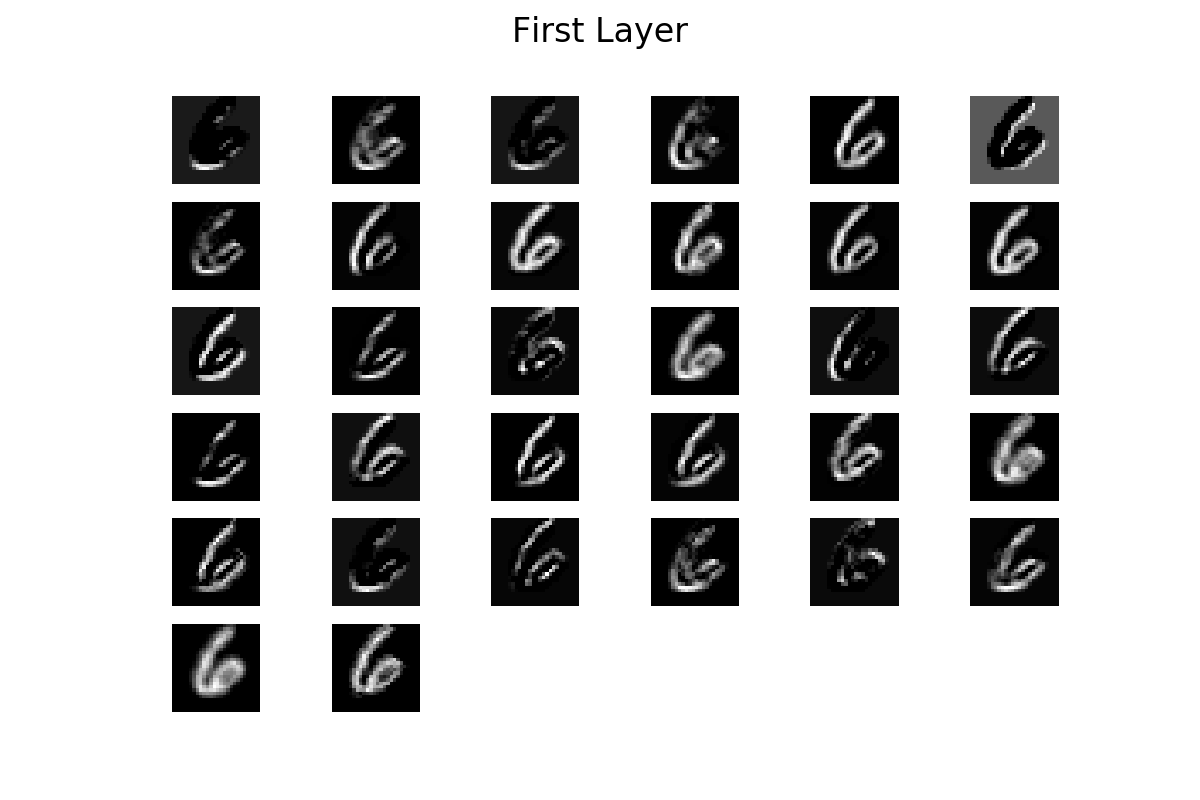

Shape of conv: (24, 24, 32)


<IPython.core.display.Javascript object>


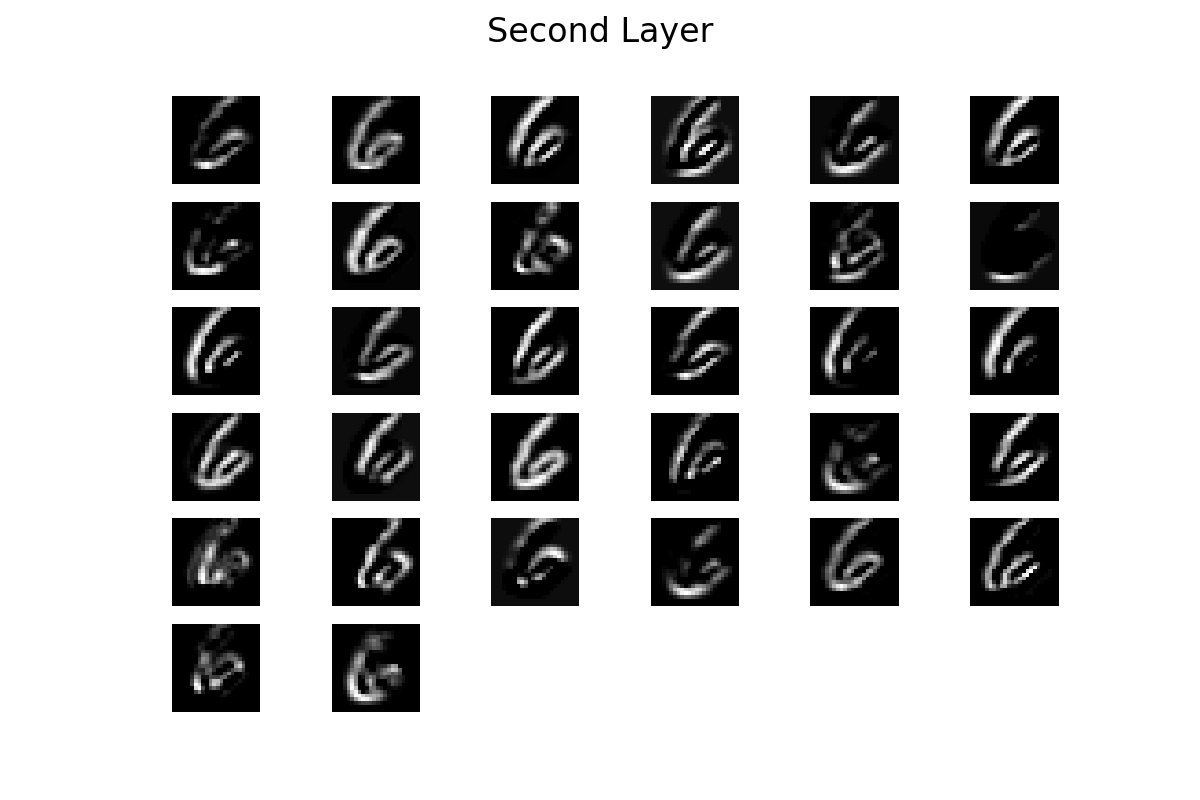

Shape of conv: (22, 22, 32)


<IPython.core.display.Javascript object>


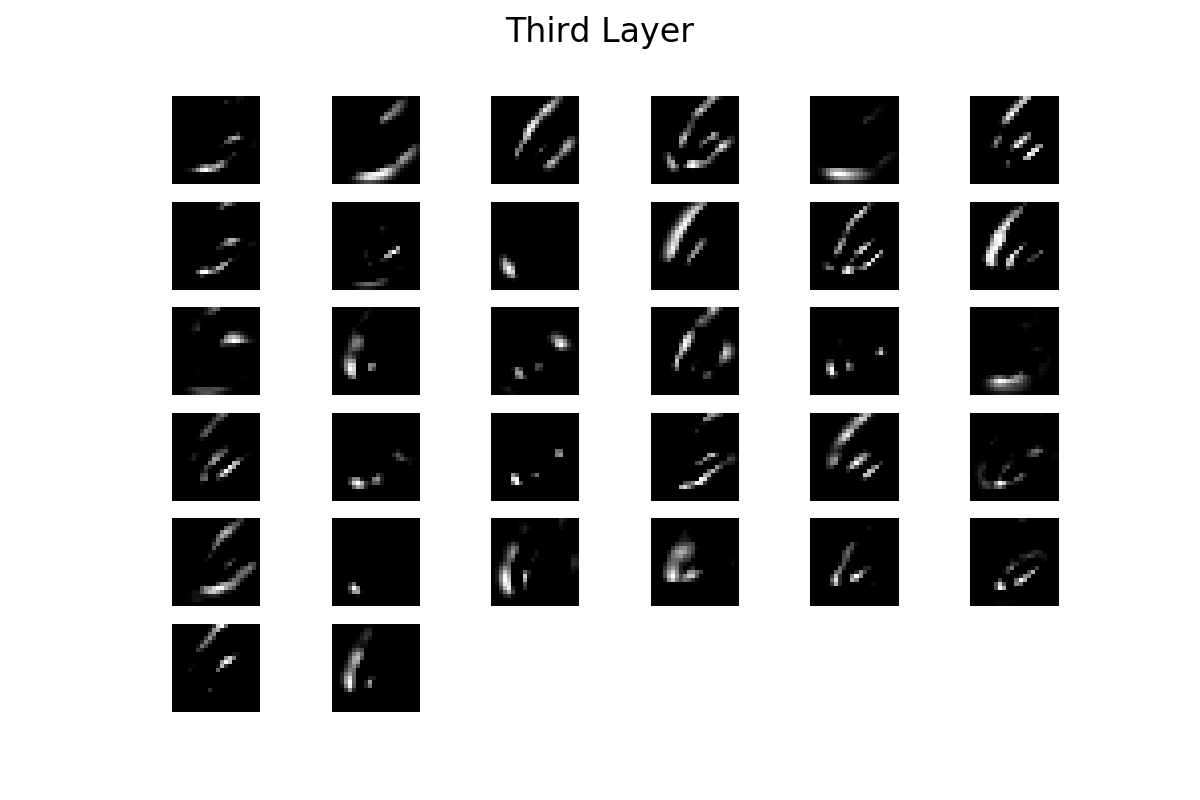

Shape of conv: (11, 11, 32)


<IPython.core.display.Javascript object>


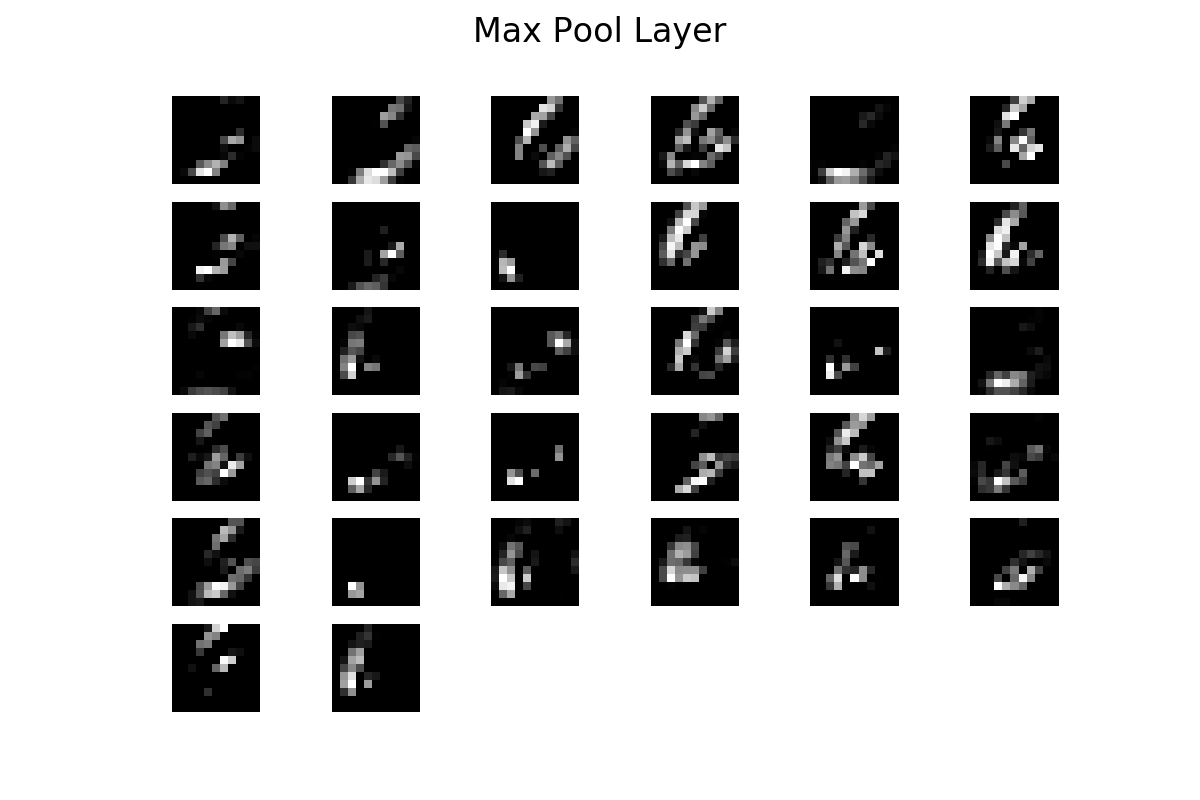

In [10]:
# Specify the layer to want to visualize
layer_to_visualize(convout1, "First Layer")

# # As convout2 is the result of a MaxPool2D layer
# # We can see that the image has blurred since
# # the resolution has reduced 
layer_to_visualize(convout2, "Second Layer")

layer_to_visualize(convout3, "Third Layer")

layer_to_visualize(maxout, "Max Pool Layer")



<IPython.core.display.Javascript object>


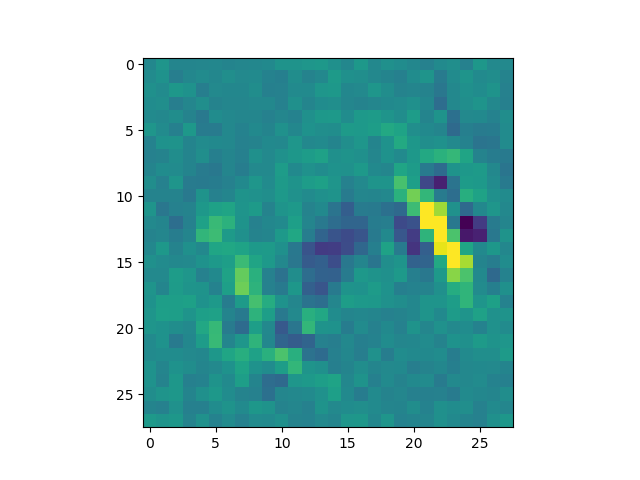

In [44]:
# dimensions of the generated pictures for each filter.
img_width = 28
img_height = 28

# util function to convert a tensor into a valid image

def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + K.epsilon())
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    if K.image_data_format() == 'channels_first':
        x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x

def normalize(x):
    # utility function to normalize a tensor by its L2 norm
    return x / (K.sqrt(K.mean(K.square(x))) + K.epsilon())

# This is the output node we want to maximize.
filter_idx = 8
img = visualize_activation(model, layer_idx, filter_indices=filter_idx)
plt.figure()
plt.imshow(img[..., 0])

from vis.visualization import visualize_activation
from vis.utils import utils
from keras import activations

model.layers[-1].activation = activations.linear
model = utils.apply_modifications(model)

layer_dict = dict([(layer.name, layer) for layer in model.layers])

layers_to_visualize = ["Conv1D_1", "Conv1D_2", "Conv1D_3"]

inputs = [K.learning_phase()] + model.inputs

input_img = model.input

loss = K.mean(model.output[:, 0])

# we compute the gradient of the input picture wrt this loss
grads = K.gradients(loss, input_img)[0]

# normalization trick: we normalize the gradient
grads = normalize(grads)

# this function returns the loss and grads given the input picture
iterate = K.function([input_img], [loss, grads])

# step size for gradient ascent
step = 1.

input_img_data = np.random.random((1, img_width, img_height, 1))
#         input_img_data = np.expand_dims(np.copy(X_train[58]), axis=0)
input_img_data = (input_img_data - 0.5) * 20 + 128

# we run gradient ascent for 20 steps
for i in range(20):
    loss_value, grads_value = iterate([input_img_data])
    input_img_data += grads_value * step

#             print('Current loss value:', loss_value)
    if loss_value <= 0.:
        # some filters get stuck to 0, we can skip them
        break

# decode the resulting input image
#         if loss_value > 0:
img = deprocess_image(input_img_data[0])

plt.figure()
plt.imshow(img.reshape(28, 28))
plt.show()

## Deeper example

[Adapted from kaggle notebook](https://www.kaggle.com/yassineghouzam/introduction-to-cnn-keras-0-997-top-6/notebook)

In [6]:
model = Sequential()

# note the padding argument here keeps the image size the same...and prevents the shrinking
# also note the larger kernel
model.add(Convolution2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
convout1 = Activation('relu')
model.add(convout1)
model.add(Convolution2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
convout2 = Activation('relu')
model.add(convout2)
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Convolution2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
convout3 = Activation('relu')
model.add(convout3)
model.add(Convolution2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
convout4 = Activation('relu')
model.add(convout4)
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=3, verbose=1)

model.fit(X_train, y_train, batch_size=512, epochs=100, validation_data=(X_test, y_test), callbacks=[early_stop])

model.summary()
score = model.evaluate(X_test, y_test)
print(score)

y_pred = model.predict(X_test)
cm = metrics.confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))

print("Classification report for classifier %s:\n%s\n"
      % (model, metrics.classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1))))
print("Confusion matrix:\n%s" % cm)

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 6s 96us/step - loss: 0.4126 - acc: 0.8658 - val_loss: 0.0681 - val_acc: 0.9777
Epoch 2/100
60000/60000 [==============================] - 4s 71us/step - loss: 0.0939 - acc: 0.9720 - val_loss: 0.0338 - val_acc: 0.9886
Epoch 3/100
60000/60000 [==============================] - 4s 71us/step - loss: 0.0660 - acc: 0.9794 - val_loss: 0.0306 - val_acc: 0.9891
Epoch 4/100
60000/60000 [==============================] - 4s 71us/step - loss: 0.0541 - acc: 0.9830 - val_loss: 0.0261 - val_acc: 0.9906
Epoch 5/100
60000/60000 [==============================] - 4s 70us/step - loss: 0.0448 - acc: 0.9866 - val_loss: 0.0232 - val_acc: 0.9928
Epoch 6/100
60000/60000 [==============================] - 4s 70us/step - loss: 0.0373 - acc: 0.9885 - val_loss: 0.0212 - val_acc: 0.9930
Epoch 7/100
60000/60000 [==============================] - 4s 70us/step - loss: 0.0346 - acc: 0.9894 - val_loss: 0.0188 - 

In [10]:
import gc
del model
K.clear_session()
gc.collect()

0

In [18]:
print(X_train[58].shape)

(28, 28, 1)


<IPython.core.display.Javascript object>


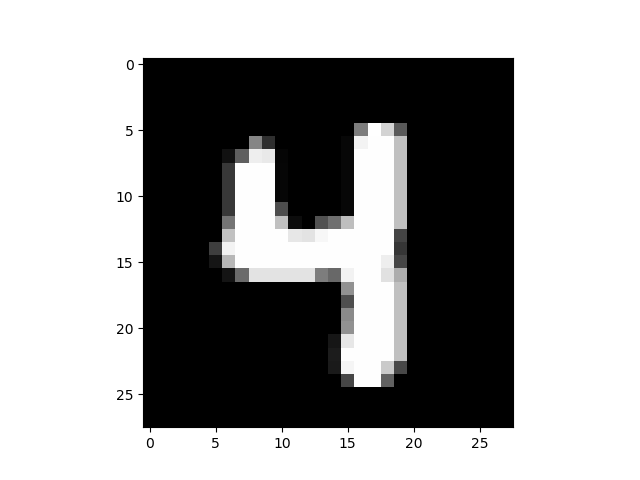

In [7]:
plt.figure()
plt.imshow(X_train[58].reshape((28,28)), cmap="gray")
plt.show()

In [10]:
# choose any image to want by specifying the index
img_to_visualize = X_train[58]
# Keras requires the image to be in 4D
# So we add an extra dimension to it.
img_to_visualize = np.expand_dims(img_to_visualize, axis=0)

def layer_to_visualize(layer, my_title):
    """
    compute the output of the convolutional and maxpool layers
    
    requires the use of particular backend flags to turn off
    training behavior
    """
    inputs = [K.learning_phase()] + model.inputs

    _convout1_f = K.function(inputs, [layer.output])
    def convout1_f(X):
        # The [0] is to disable the training phase flag
        return _convout1_f([0] + [X])

    # compute the convolutional output of the layer given
    # the input image
    # e.g. The first layer will take a 28x28 image and will use
    # a Convolution2D layer to pass a 3x3 kernel to create 32 filters
    # meaning 1 28x28x1 image becomes 32 26x26x1 images
    convolutions = convout1_f(img_to_visualize)
    # use the squeeze function dump the channel data
    convolutions = np.squeeze(convolutions)

    print ('Shape of conv:', convolutions.shape)
    
    # technically this is "backward" from the original example
    # this is because we are using a slightly different API to
    # pass our images into the network
    n = convolutions.shape[2]
    n = int(np.ceil(np.sqrt(n)))
    
    # Visualization of each filter of the layer
    fig = plt.figure(figsize=(12,8))
#     for i in range(convolutions.shape[2]):
#         ax = fig.add_subplot(n,n,i+1)
#         ax.axis('off')
#         ax.imshow(convolutions[:,:,i], cmap='gray')
    for i in range(4):
        for j in range(8):
            try:
                img, loss = kept_filters[i * 8 + j]
                ax = fig.add_subplot(4,8,i * 8 + j + 1)
                ax.axis('off')
                ax.imshow(convolutions[:,:,i*8+j], cmap='gray')
            except:
                pass
    fig.suptitle(my_title, fontsize=24)

Shape of conv: (28, 28, 32)


<IPython.core.display.Javascript object>


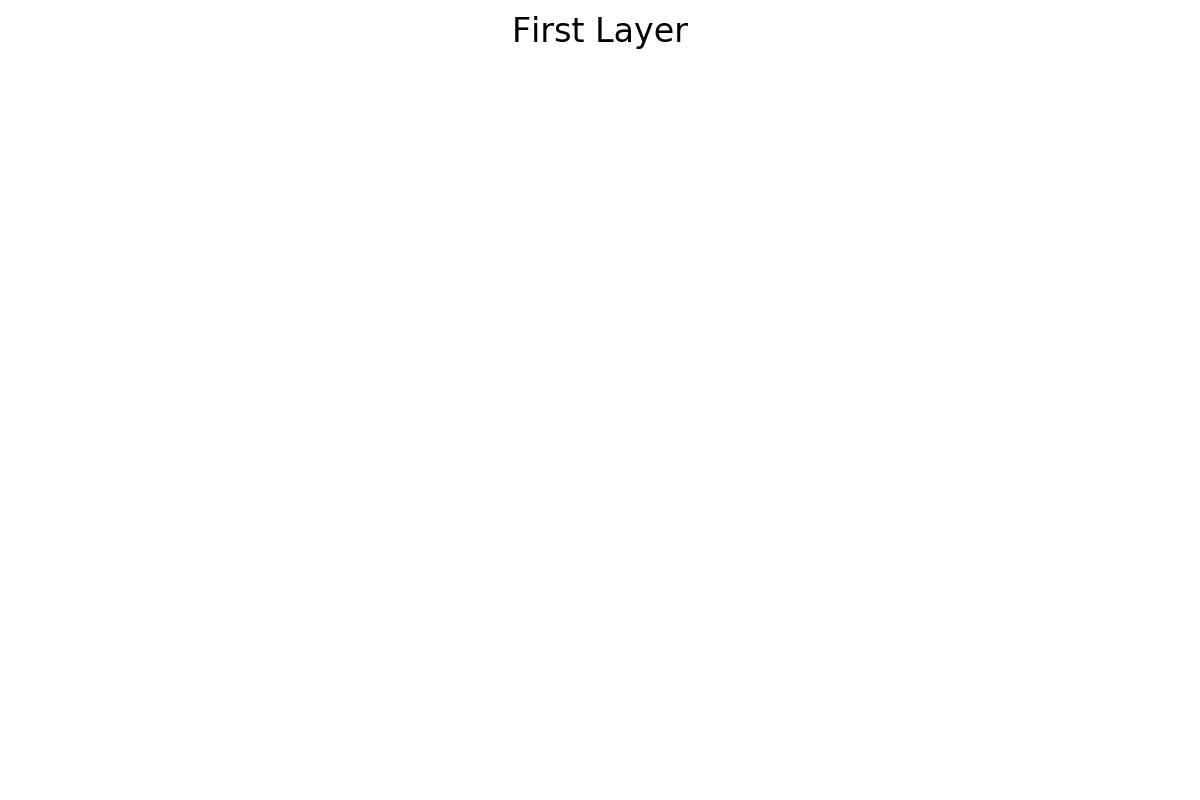

In [11]:
# Specify the layer to want to visualize
layer_to_visualize(convout1, "First Layer")

# # As convout2 is the result of a MaxPool2D layer
# # We can see that the image has blurred since
# # the resolution has reduced 
# layer_to_visualize(convout2, "Second Layer")

# layer_to_visualize(convout3, "Third Layer")

# layer_to_visualize(convout4, "Fourth Layer")



In [11]:
print(y_train[58])
print(model.predict(np.expand_dims(X_train[58], axis=0)))
print(model.predict(np.expand_dims(X_train[58], axis=0)).argmax(axis=1))

[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
[[2.9810996e-16 6.4502923e-09 5.9637467e-13 3.7923790e-13 1.0000000e+00
  4.6379312e-13 1.5561169e-12 1.7324563e-10 8.5980965e-11 8.1435658e-09]]
[4]


# kernel visualization

https://blog.keras.io/category/demo.html

In [20]:
model = Sequential()

# note the padding argument here keeps the image size the same...and prevents the shrinking
# also note the larger kernel
model.add(Convolution2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
convout1 = Activation('relu')
model.add(convout1)
model.add(Convolution2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
convout2 = Activation('relu')
model.add(convout2)
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Convolution2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
convout3 = Activation('relu')
model.add(convout3)
model.add(Convolution2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
convout4 = Activation('relu')
model.add(convout4)
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, batch_size=128, nb_epoch=10, validation_data=(X_test, y_test))

model.summary()

/home/harperes/miniconda3/envs/ml/lib/python3.6/site-packages/ipykernel_launcher.py:35: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 8s 125us/step - loss: 0.2204 - acc: 0.9289 - val_loss: 0.0420 - val_acc: 0.9857
Epoch 2/10
60000/60000 [==============================] - 7s 117us/step - loss: 0.0632 - acc: 0.9808 - val_loss: 0.0320 - val_acc: 0.9890
Epoch 3/10
60000/60000 [==============================] - 7s 117us/step - loss: 0.0495 - acc: 0.9854 - val_loss: 0.0219 - val_acc: 0.9926
Epoch 4/10
60000/60000 [==============================] - 7s 115us/step - loss: 0.0404 - acc: 0.9879 - val_loss: 0.0212 - val_acc: 0.9925
Epoch 5/10
60000/60000 [==============================] - 7s 114us/step - loss: 0.0342 - acc: 0.9899 - val_loss: 0.0212 - val_acc: 0.9931
Epoch 6/10
60000/60000 [==============================] - 7s 114us/step - loss: 0.0309 - acc: 0.9907 - val_loss: 0.0187 - val_acc: 0.9935
Epoch 7/10
60000/60000 [==============================] - 7s 119us/step - loss: 0.0269 - acc: 0.9916 - val_loss: 0.0225 - 

(5, 5, 1, 32)


<IPython.core.display.Javascript object>


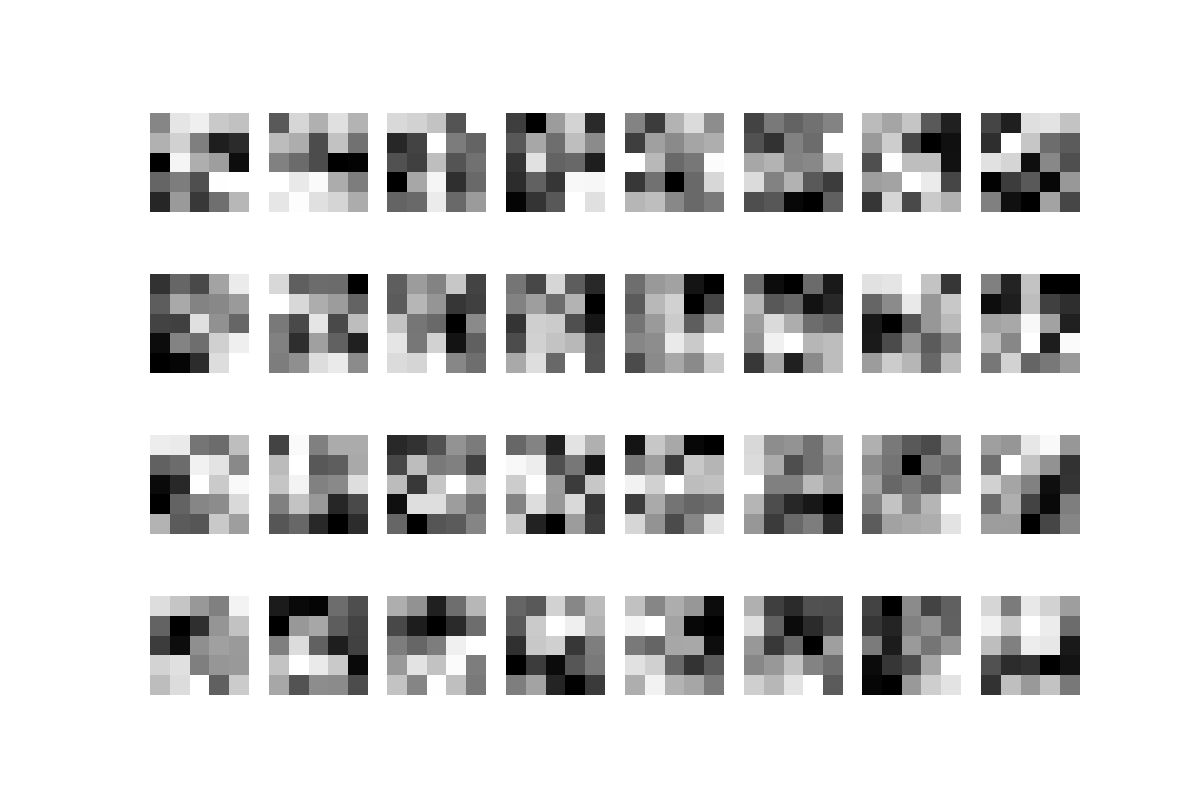

In [12]:
#get_weights [x, y, channel, nth convolutions layer ]
# print(len(model.layers))
# print(len(model.layers[0].get_weights()))
print(model.layers[0].get_weights()[0].shape)
weight_conv2d_1 = model.layers[0].get_weights()[0][:,:,0,:]
 
col_size = 8
row_size = 4
filter_index = 0
fig, ax = plt.subplots(row_size, col_size, figsize=(12,8))
for row in range(0,row_size): 
    for col in range(0,col_size):
        ax[row][col].imshow(weight_conv2d_1[:,:,filter_index],cmap="gray")
        ax[row][col].axis("off")
        filter_index += 1

## First Layer

In [14]:
import time
# dimensions of the generated pictures for each filter.
img_width = 28
img_height = 28

# the name of the layer we want to visualize
layer_name = 'conv2d_1'

# util function to convert a tensor into a valid image

def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + K.epsilon())
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    if K.image_data_format() == 'channels_first':
        x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x


# # build the VGG16 network with ImageNet weights
# model = vgg16.VGG16(weights='imagenet', include_top=False)
# print('Model loaded.')

model.summary()

# this is the placeholder for the input images
input_img = model.input
# input_img = np.expand_dims(X_train[1], axis=0)
# input_img *= 255
# input_img = input_img.astype('float')

# get the symbolic outputs of each "key" layer (we gave them unique names).
layer_dict = dict([(layer.name, layer) for layer in model.layers])
print(layer_dict.keys())


def normalize(x):
    # utility function to normalize a tensor by its L2 norm
    print(x)
    return x / (K.sqrt(K.mean(K.square(x))) + K.epsilon())


kept_filters = []
for filter_index in range(32):
    # we only scan through the first 200 filters,
    # but there are actually 512 of them
    print('Processing filter %d' % filter_index)
    start_time = time.time()

    # we build a loss function that maximizes the activation
    # of the nth filter of the layer considered
    layer_output = layer_dict[layer_name].output
#     layer_output = convout1.output
    if K.image_data_format() == 'channels_first':
        loss = K.mean(layer_output[:, filter_index, :, :])
    else:
        loss = K.mean(layer_output[:, :, :, filter_index])
    loss = K.mean(layer_output[:, :, :, filter_index])
    # we compute the gradient of the input picture wrt this loss
    grads = K.gradients(loss, input_img)[0]

    # normalization trick: we normalize the gradient
    grads = normalize(grads)

    # this function returns the loss and grads given the input picture
    iterate = K.function([input_img], [loss, grads])

    # step size for gradient ascent
    step = 1.

    # we start from a gray image with some random noise
#     if K.image_data_format() == 'channels_first':
#         input_img_data = np.random.random((1, 3, img_width, img_height))
#     else:
#         input_img_data = np.random.random((1, img_width, img_height, 3))
#     input_img_data = (input_img_data - 0.5) * 20 + 128
    if K.image_data_format() == 'channels_first':
        input_img_data = np.random.random((1, 3, img_width, img_height))
    else:
        input_img_data = np.random.random((1, img_width, img_height, 1))
    input_img_data = np.expand_dims(np.copy(X_train[58]), axis=0)
    input_img_data = (input_img_data - 0.5) * 20 + 128

    # we run gradient ascent for 20 steps
    for i in range(20):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step

        print('Current loss value:', loss_value)
        if loss_value <= 0.:
            # some filters get stuck to 0, we can skip them
            break

    # decode the resulting input image
    if loss_value > 0:
        img = deprocess_image(input_img_data[0])
        kept_filters.append((img, loss_value))
    end_time = time.time()
    print('Filter %d processed in %ds' % (filter_index, end_time - start_time))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        832       
_________________________________________________________________
activation_1 (Activation)    (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        25632     
_________________________________________________________________
activation_2 (Activation)    (None, 28, 28, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        18496     
__________

Current loss value: 11.840222
Current loss value: 12.055794
Current loss value: 12.277543
Current loss value: 12.508463
Current loss value: 12.7455
Current loss value: 12.990486
Current loss value: 13.24004
Current loss value: 13.493253
Current loss value: 13.751796
Current loss value: 14.015036
Current loss value: 14.2803135
Current loss value: 14.54821
Current loss value: 14.818865
Current loss value: 15.09238
Current loss value: 15.369131
Current loss value: 15.648339
Current loss value: 15.928463
Current loss value: 16.208694
Current loss value: 16.490376
Current loss value: 16.773415
Filter 8 processed in 0s
Processing filter 9
Tensor("gradients_9/conv2d_1/convolution_grad/Conv2DBackpropInput:0", shape=(?, 28, 28, 1), dtype=float32)
Current loss value: 8.967001
Current loss value: 9.082334
Current loss value: 9.197665
Current loss value: 9.313
Current loss value: 9.428333
Current loss value: 9.544099
Current loss value: 9.660624
Current loss value: 9.777582
Current loss value: 9.8

Current loss value: 1.2020748
Current loss value: 1.246644
Current loss value: 1.291213
Current loss value: 1.3357825
Current loss value: 1.3803518
Current loss value: 1.425126
Current loss value: 1.4754181
Current loss value: 1.5278249
Current loss value: 1.5840788
Current loss value: 1.6403327
Current loss value: 1.6965867
Current loss value: 1.752841
Current loss value: 1.812236
Current loss value: 1.8733919
Current loss value: 1.9345483
Current loss value: 1.99797
Current loss value: 2.0638955
Current loss value: 2.1336262
Current loss value: 2.2033567
Current loss value: 2.2730873
Filter 21 processed in 0s
Processing filter 22
Tensor("gradients_22/conv2d_1/convolution_grad/Conv2DBackpropInput:0", shape=(?, 28, 28, 1), dtype=float32)
Current loss value: 1.6828161
Current loss value: 1.8092749
Current loss value: 1.9388499
Current loss value: 2.0739346
Current loss value: 2.2116528
Current loss value: 2.3520088
Current loss value: 2.4936602
Current loss value: 2.6361754
Current loss

In [34]:
# we will stich the best 64 filters on a 8 x 8 grid.
n = 6

# the filters that have the highest loss are assumed to be better-looking.
# we will only keep the top 64 filters.
# kept_filters.sort(key=lambda x: x[1], reverse=True)
# kept_filters = kept_filters[:n * n]

# # build a black picture with enough space for
# # our 8 x 8 filters of size 128 x 128, with a 5px margin in between
# margin = 5
# width = n * img_width + (n - 1) * margin
# height = n * img_height + (n - 1) * margin
# stitched_filters = np.zeros((width, height, 3))

32


<IPython.core.display.Javascript object>


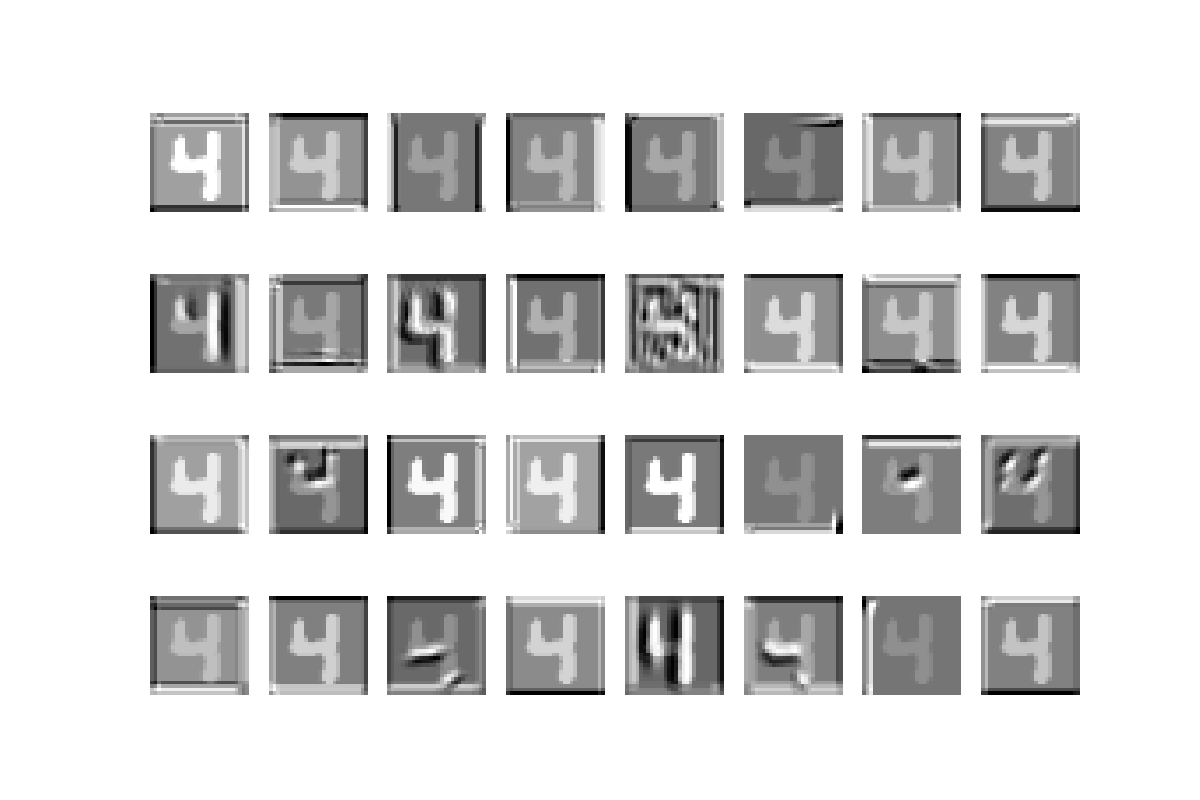

In [15]:
print(len(kept_filters))
# why is this 31 and not 32...oh well
# Visualization of each filter of the layer
fig = plt.figure(figsize=(12,8))
for i in range(4):
    for j in range(8):
        try:
            img, loss = kept_filters[i * 8 + j]
            ax = fig.add_subplot(4,8,i * 8 + j + 1)
            ax.axis('off')
            ax.imshow(img.reshape(28,28), cmap='gray')
        except:
            pass
# for i in range(convolutions.shape[2]):
#     ax = fig.add_subplot(n,n,i+1)
#     ax.imshow(convolutions[:,:,i], cmap='gray')

## Deepest Layer

In [61]:
import time
# dimensions of the generated pictures for each filter.
img_width = 28
img_height = 28

# the name of the layer we want to visualize
layer_name = 'conv2d_8'

# util function to convert a tensor into a valid image

def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + K.epsilon())
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    if K.image_data_format() == 'channels_first':
        x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x


# # build the VGG16 network with ImageNet weights
# model = vgg16.VGG16(weights='imagenet', include_top=False)
# print('Model loaded.')

model.summary()

# this is the placeholder for the input images
input_img = model.input
# input_img = np.expand_dims(X_train[1], axis=0)
# input_img *= 255
# input_img = input_img.astype('float')

# get the symbolic outputs of each "key" layer (we gave them unique names).
layer_dict = dict([(layer.name, layer) for layer in model.layers[1:]])
print(layer_dict.keys())


def normalize(x):
    # utility function to normalize a tensor by its L2 norm
    print(x)
    return x / (K.sqrt(K.mean(K.square(x))) + K.epsilon())


kept_filters = []
for filter_index in range(64):
    # we only scan through the first 200 filters,
    # but there are actually 512 of them
    print('Processing filter %d' % filter_index)
    start_time = time.time()

    # we build a loss function that maximizes the activation
    # of the nth filter of the layer considered
    layer_output = layer_dict[layer_name].output
#     layer_output = convout1.output
    if K.image_data_format() == 'channels_first':
        loss = K.mean(layer_output[:, filter_index, :, :])
    else:
        loss = K.mean(layer_output[:, :, :, filter_index])
#     loss = K.mean(layer_output[:, :, :, filter_index])
    loss = K.mean(model.output[:,5])
    # we compute the gradient of the input picture wrt this loss
    grads = K.gradients(loss, input_img)[0]

    # normalization trick: we normalize the gradient
    grads = normalize(grads)

    # this function returns the loss and grads given the input picture
    iterate = K.function([input_img], [loss, grads])

    # step size for gradient ascent
    step = 1.

    # we start from a gray image with some random noise
#     if K.image_data_format() == 'channels_first':
#         input_img_data = np.random.random((1, 3, img_width, img_height))
#     else:
#         input_img_data = np.random.random((1, img_width, img_height, 3))
#     input_img_data = (input_img_data - 0.5) * 20 + 128
    if K.image_data_format() == 'channels_first':
        input_img_data = np.random.random((1, 3, img_width, img_height))
    else:
        input_img_data = np.random.random((1, img_width, img_height, 1))
#     input_img_data = np.expand_dims(np.copy(X_train[58]), axis=0)
    input_img_data = (input_img_data - 0.5) * 20 + 128

    # we run gradient ascent for 20 steps
    for i in range(20):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step

        print('Current loss value:', loss_value)
        if loss_value <= 0.:
            # some filters get stuck to 0, we can skip them
            break

    # decode the resulting input image
#     if loss_value > 0:
#         img = deprocess_image(input_img_data[0])
#         kept_filters.append((img, loss_value))
    img = deprocess_image(input_img_data[0])
    kept_filters.append((img, loss_value))
    end_time = time.time()
    print('Filter %d processed in %ds' % (filter_index, end_time - start_time))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 28, 28, 32)        832       
_________________________________________________________________
activation_5 (Activation)    (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 28, 28, 32)        25632     
_________________________________________________________________
activation_6 (Activation)    (None, 28, 28, 32)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 14, 14, 64)        18496     
__________

KeyboardInterrupt: 

In [37]:
# we will stich the best 64 filters on a 8 x 8 grid.
n = 6

# the filters that have the highest loss are assumed to be better-looking.
# we will only keep the top 64 filters.
# kept_filters.sort(key=lambda x: x[1], reverse=True)
# kept_filters = kept_filters[:n * n]

# build a black picture with enough space for
# our 8 x 8 filters of size 128 x 128, with a 5px margin in between
margin = 5
width = n * img_width + (n - 1) * margin
height = n * img_height + (n - 1) * margin
stitched_filters = np.zeros((width, height, 3))

In [52]:
print(len(kept_filters))

64


<IPython.core.display.Javascript object>


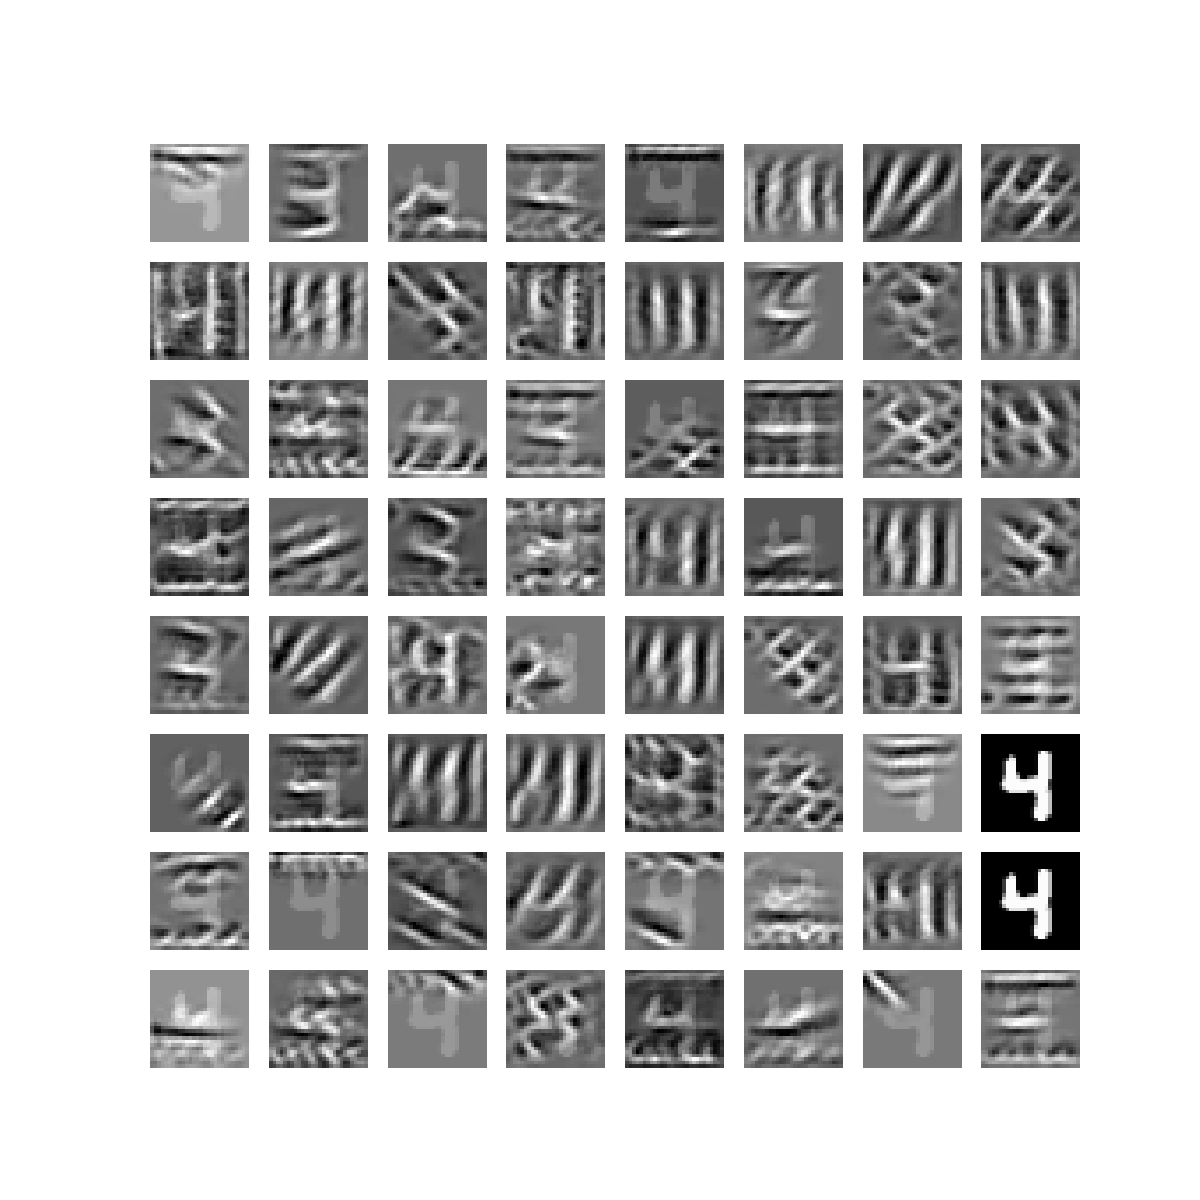

In [60]:
# Visualization of each filter of the layer
fig = plt.figure(figsize=(12,12))
n=8
for i in range(8):
    for j in range(8):
        img, loss = kept_filters[i * n + j]
        ax = fig.add_subplot(8,8,i * n + j + 1)
        ax.axis('off')
        ax.imshow(img.reshape(28,28), cmap='gray')
# for i in range(convolutions.shape[2]):
#     ax = fig.add_subplot(n,n,i+1)
#     ax.imshow(convolutions[:,:,i], cmap='gray')

Copied code from keras

In [25]:
import time
# dimensions of the generated pictures for each filter.
img_width = 28
img_height = 28

# util function to convert a tensor into a valid image

def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + K.epsilon())
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    if K.image_data_format() == 'channels_first':
        x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x


# # build the VGG16 network with ImageNet weights
# model = vgg16.VGG16(weights='imagenet', include_top=False)
# print('Model loaded.')

model.summary()

# this is the placeholder for the input images
input_img = model.input
# input_img = np.expand_dims(X_train[1], axis=0)
# input_img *= 255
# input_img = input_img.astype('float')

def normalize(x):
    # utility function to normalize a tensor by its L2 norm
    print(x)
    return x / (K.sqrt(K.mean(K.square(x))) + K.epsilon())


kept_filters = []
print(model.output.shape)
loss = K.mean(model.output[:, 8])
# we compute the gradient of the input picture wrt this loss
grads = K.gradients(loss, input_img)[0]

# normalization trick: we normalize the gradient
grads = normalize(grads)

# this function returns the loss and grads given the input picture
iterate = K.function([input_img], [loss, grads])

# step size for gradient ascent
step = 1.

# we start from a gray image with some random noise
#     if K.image_data_format() == 'channels_first':
#         input_img_data = np.random.random((1, 3, img_width, img_height))
#     else:
#         input_img_data = np.random.random((1, img_width, img_height, 3))
#     input_img_data = (input_img_data - 0.5) * 20 + 128
if K.image_data_format() == 'channels_first':
    input_img_data = np.random.random((1, 3, img_width, img_height))
else:
    input_img_data = np.random.random((1, img_width, img_height, 1))
input_img_data = np.expand_dims(np.copy(X_train[58]), axis=0)
input_img_data = (input_img_data - 0.5) * 20 + 128

# we run gradient ascent for 20 steps
for i in range(20):
    loss_value, grads_value = iterate([input_img_data])
    input_img_data += grads_value * step

    print('Current loss value:', loss_value)
    if loss_value <= 0.:
        # some filters get stuck to 0, we can skip them
        break

# decode the resulting input image
#     if loss_value > 0:
#         img = deprocess_image(input_img_data[0])
#         kept_filters.append((img, loss_value))
img = deprocess_image(input_img_data[0])
kept_filters.append((img, loss_value))
end_time = time.time()
# print('Filter %d processed in %ds' % (filter_index, end_time - start_time))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        832       
_________________________________________________________________
activation_1 (Activation)    (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        25632     
_________________________________________________________________
activation_2 (Activation)    (None, 28, 28, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        18496     
__________

In [26]:
img, loss = kept_filters[0]
input_test = np.expand_dims(img, axis=0)
y_out = model.predict(input_test)
print(y_out)

[[-1316.2394  -1480.4016   -406.4565    285.29068  -810.73016   966.66833
     65.3052  -1863.6533   3997.9863   -129.81061]]


<IPython.core.display.Javascript object>


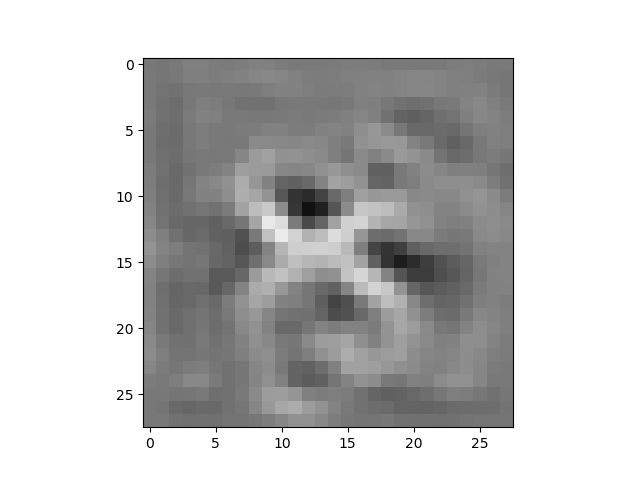

In [27]:
plt.figure()
img, loss = kept_filters[0]
plt.imshow(img.reshape((28,28)), vmin=0, vmax=255, cmap="gray")
plt.show()

dict_keys(['activation_1', 'conv2d_2', 'activation_2', 'max_pooling2d_1', 'dropout_1', 'conv2d_3', 'activation_3', 'conv2d_4', 'activation_4', 'max_pooling2d_2', 'dropout_2', 'flatten_1', 'dense_1', 'dropout_3', 'dense_2'])


<IPython.core.display.Javascript object>


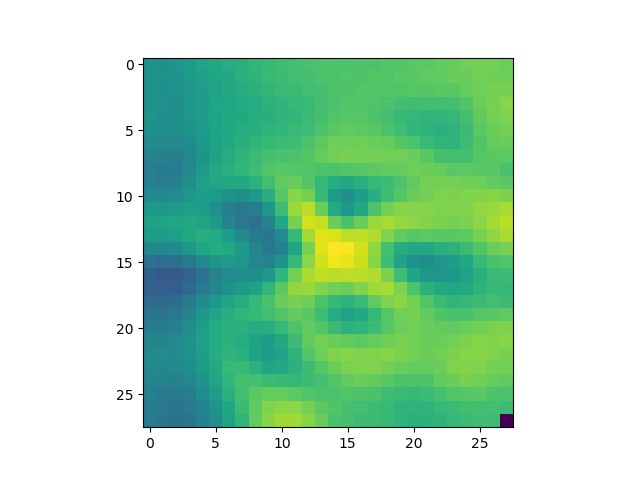

In [24]:
from vis.visualization import visualize_activation
from vis.utils import utils
from keras import activations

# Utility to search for layer index by name.
# Alternatively we can specify this as -1 since it corresponds to the last layer.
layer_dict = dict([(layer.name, layer) for layer in model.layers[1:]])
print(layer_dict.keys())
layer_idx = utils.find_layer_idx(model, 'dense_2')

# Swap softmax with linear
model.layers[layer_idx].activation = activations.linear
model = utils.apply_modifications(model)

# This is the output node we want to maximize.
filter_idx = 8
img = visualize_activation(model, layer_idx, filter_indices=filter_idx)
plt.figure()
plt.imshow(img[..., 0])


In [ ]:
# fill the picture with our saved filters
for i in range(n):
    for j in range(n):
        img, loss = kept_filters[i * n + j]
        width_margin = (img_width + margin) * i
        height_margin = (img_height + margin) * j
        stitched_filters[
            width_margin: width_margin + img_width,
            height_margin: height_margin + img_height, :] = img

In [ ]:
plt.figure()
plt.imshow(stitched_filters)

In [ ]:
from scipy.misc import imsave
# save the result to disk
save_img('stitched_filters_%dx%d.png' % (n, n), stitched_filters)

## Original Visualization Example

[Link to original example](https://github.com/yashk2810/Visualization-of-Convolutional-Layers/blob/master/Visualizing%20Filters%20Python3%20Theano%20Backend.ipynb)

In [ ]:
# Model 
new_model = Sequential()

new_model.add(Convolution2D(32, (3, 3), input_shape=(28,28,1))) 
convout1 = Activation('relu')
new_model.add(convout1)
convout2 = MaxPooling2D()
new_model.add(convout2)

new_model.add(Flatten())

new_model.add(Dense(128))
new_model.add(Activation('relu'))
new_model.add(Dropout(0.2))
new_model.add(Dense(10))
new_model.add(Activation('softmax'))

new_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
new_model.fit(X_train, y_train, batch_size=128, nb_epoch=5, validation_data=(X_test, y_test))

In [ ]:
# choose any image to want by specifying the index
img_to_visualize = X_train[1]
# Keras requires the image to be in 4D
# So we add an extra dimension to it.
img_to_visualize = np.expand_dims(img_to_visualize, axis=0)
print(img_to_visualize.shape)
# print(new_model.inputs)

def layer_to_visualize(layer):
    inputs = [K.learning_phase()] + new_model.inputs

    _convout1_f = K.function(inputs, [layer.output])
    def convout1_f(X):
        # The [0] is to disable the training phase flag
        return _convout1_f([0] + [X])

    convolutions = convout1_f(img_to_visualize)
    convolutions = np.squeeze(convolutions)

    print ('Shape of conv:', convolutions.shape)
    
    n = convolutions.shape[2]
    n = int(np.ceil(np.sqrt(n)))
    
    # Visualization of each filter of the layer
    fig = plt.figure(figsize=(12,8))
    for i in range(convolutions.shape[2]):
        ax = fig.add_subplot(n,n,i+1)
        ax.imshow(convolutions[:,:,i], cmap='gray')

In [ ]:
# Specify the layer to want to visualize
layer_to_visualize(convout1)

# # As convout2 is the result of a MaxPool2D layer
# # We can see that the image has blurred since
# # the resolution has reduced 
layer_to_visualize(convout2)

